### <font color="Orange"> **Name** : **Rishabh Satish Mer** </font>
### <font color="Skyblue"> **Student ID** : **22200186** </font>

#### **Dataset Assigned** : **Image**

#### **Dataset** : [Wikiart](https://www.kaggle.com/datasets/simolopes/wikiart-all-artpieces)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/archive.zip

In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/






In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms, models

from torchinfo import summary

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.express as px

%matplotlib inline


import os
from pathlib import Path
import shutil
import random
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

from timeit import default_timer as timer

from typing import List, Dict, Tuple, Set

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device using: {device}")

Device using: cuda


#### Converting images to ```RBG``` format and checking for ```corrupted images```

In [3]:

wikiart_dataset_path = "/content/wikiart/wikiart/"

count = 0
image_mode_not_rbg_count = 0 

for _, _, filesnames in os.walk(wikiart_dataset_path):
  print("---")
  # print(filesnames)
  for files in range(len(filesnames)):
    files = filesnames[files]
    # print(f"Images: {files}")
    try:
      size = os.path.getsize(os.path.join(wikiart_dataset_path, files))
      # print(f"size: {size}")
      if size == 0:
        print(files)
        
      image = Image.open(os.path.join(wikiart_dataset_path, files))
      image_mode = image.mode

      # print(f"Image Mode: {image_mode}")
        
      if image_mode != "RGB":
          image_mode_not_rbg_count = image_mode_not_rbg_count + 1
          image = image.convert("RGB")
          image.save(os.path.join(wikiart_dataset_path, files))

    except OSError as e:
        count = count + 1
#         print(f"Image file: {files} is truncated, exception raised: {e}")

print(f"\nImages converted to RGB: {image_mode_not_rbg_count}")
print(f"Corrupted Images Count: {count}")



---


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Images converted to RGB: 2374
Corrupted Images Count: 2374


In [4]:
!nvidia-smi

Sun Apr 30 22:18:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Creating Dataframe

In [5]:
wikiart_df = pd.read_csv("/content/wikiart_art_pieces.csv")
wikiart_df.head(5)

,artist,style,genre,movement,tags,url,img,file_name
0,Byzantine Mosaics,Early Byzantine (c. 330–750),religious painting,Byzantine Art,"['Holyplaces', 'Byzantinearchitecture', 'Arch'...",https://www.wikiart.org/en/byzantine-mosaics/e...,https://uploads2.wikiart.org/00211/images/byza...,0-ravenna-cappella-arcivescovile-166.jpg
1,Byzantine Mosaics,Early Byzantine (c. 330–750),religious painting,Byzantine Art,"['Holyplaces', 'Byzantinearchitecture', 'Arch']",https://www.wikiart.org/en/byzantine-mosaics/e...,https://uploads2.wikiart.org/00211/images/byza...,1-ravenna-cappella-arcivescovile-167.jpg
2,Byzantine Mosaics,Early Byzantine (c. 330–750),religious painting,Byzantine Art,"['Prophet', 'History']",https://www.wikiart.org/en/byzantine-mosaics/e...,https://uploads2.wikiart.org/00211/images/byza...,2-ravenna-cappella-arcivescovile-168.jpg
3,Byzantine Mosaics,Early Byzantine (c. 330–750),religious painting,Byzantine Art,"['Holyplaces', 'Prophet']",https://www.wikiart.org/en/byzantine-mosaics/e...,https://uploads2.wikiart.org/00211/images/byza...,3-ravenna-cappella-arcivescovile-169.jpg
4,Byzantine Mosaics,Early Byzantine (c. 330–750),religious painting,Byzantine Art,"['Holyplaces', 'Prophet']",https://www.wikiart.org/en/byzantine-mosaics/e...,https://uploads2.wikiart.org/00211/images/byza...,4-ravenna-cappella-arcivescovile-171.jpg


In [6]:
print(f"Shape of wikiart dataframe: {wikiart_df.shape}")

Shape of wikiart dataframe: (176436, 8)


In [7]:
wikiart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176436 entries, 0 to 176435
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   artist     176436 non-null  object
 1   style      176436 non-null  object
 2   genre      176436 non-null  object
 3   movement   176436 non-null  object
 4   tags       127710 non-null  object
 5   url        176436 non-null  object
 6   img        176436 non-null  object
 7   file_name  176436 non-null  object
dtypes: object(8)
memory usage: 10.8+ MB


In [8]:
# Checking null values
wikiart_df.isnull().sum()

artist           0
style            0
genre            0
movement         0
tags         48726
url              0
img              0
file_name        0
dtype: int64

In [9]:

print(f'Uniques Value of Movement column: {len(wikiart_df["movement"].unique())}')
print(f'Uniques Value of Artist column: {len(wikiart_df["artist"].unique())}')
print(f'Uniques Value of Style column: {len(wikiart_df["style"].unique())}')
print(f'Uniques Value of Genre column: {len(wikiart_df["genre"].unique())}')

Uniques Value of Movement column: 124
Uniques Value of Artist column: 3209
Uniques Value of Style column: 193
Uniques Value of Genre column: 646


### Counting of images by ```style column```

In [10]:
image_file_count_by_style = wikiart_df.groupby("style")["file_name"].count()

In [11]:
df = image_file_count_by_style.to_frame()

In [12]:
df.head()

,file_name
style,
Abstract Art,1729
Abstract Expressionism,3909
Academicism,2474
Action painting,105
American Realism,72


In [13]:
fig = px.scatter(df, x=df.index, y="file_name", 
                 template="plotly_dark", size="file_name", color=df.index, title="Image count by movement")
fig.show()


### From the above plot we can see that:
- There are images > 5000 for 8 style
- There are many images < 1000 for many style
- So, even with data augmentation of images < 1000 will not effect on training data and accuracy for style < 1000 images will be low

In [14]:
df = df[(df["file_name"] > 2000) & (df["file_name"] < 5000)]

In [15]:
style_list = df.index.to_list()
print(f"Selected Style Lists: {style_list}")

Selected Style Lists: ['Abstract Expressionism', 'Academicism', 'Cubism', 'Minimalism', 'Neoclassicism', 'Northern Renaissance', 'Pop Art', 'Rococo']


### Creating new DataFrame and random sampling the dataframe by ```2023```

In [16]:
new_wikiart_df = wikiart_df.loc[wikiart_df["style"].isin(df.index)]
new_wikiart_df = new_wikiart_df.sample(frac=1, random_state=2023)
new_wikiart_df.head(5)

,artist,style,genre,movement,tags,url,img,file_name
125612,Brice Marden,Abstract Expressionism,abstract,Abstract Art,NaN,https://www.wikiart.org/en/brice-marden/suicid...,https://uploads1.wikiart.org/images/brice-mard...,163859-suicide-notes-1972.jpg
161508,Erro,Pop Art,figurative,Pop Art,['Cool'],https://www.wikiart.org/en/erro/otto-e-mezzo-1970,https://uploads1.wikiart.org/images/erro/otto-...,227026-otto-e-mezzo-1970.jpg
6859,Hans Memling,Northern Renaissance,religious painting,Northern Renaissance,"['Circle', 'Pictureframe', 'Oval']",https://www.wikiart.org/en/hans-memling/virgin...,https://uploads5.wikiart.org/images/hans-memli...,7758-virgin-suckling-the-child-1490.jpg
33128,Petrus van Schendel,Academicism,no genre,Romanticism,NaN,https://www.wikiart.org/en/petrus-van-schendel...,https://uploads8.wikiart.org/00387/images/petr...,41147-f736e007c77baf03e13069904f053fb1.jpg
147470,Moshe Kupferman,Abstract Expressionism,abstract,Abstract Expressionism,NaN,https://www.wikiart.org/en/moshe-kupferman/unt...,https://uploads8.wikiart.org/images/moshe-kupf...,203350-untitled-2003.jpg


In [17]:
new_wikiart_df.shape

(24493, 8)

### Create new directory name - ```Dataset``` which contains 2 folders ```Train```, ```Val```, and ```Test```

In [18]:
current_directory = os.getcwd()
print(f"Current Directory: {current_directory}")
new_folder = "Dataset"
final_directory = os.path.join(current_directory, new_folder)

print(f"Created new directory name : {new_folder}")
os.makedirs(final_directory, exist_ok=True)
print(f"Dataset Directory : {final_directory}")


train_folder = "Train"
test_folder = "Test"
val_folder = "Val"

final_test_directory = os.path.join(final_directory, test_folder)
final_train_directory = os.path.join(final_directory, train_folder)
final_val_directory = os.path.join(final_directory, val_folder)

print(f"Directory Created: {test_folder}")
os.makedirs(final_test_directory, exist_ok=True)
print(f"Test Directory: {final_test_directory}")

print(f"Directory Created: {train_folder}")
os.makedirs(final_train_directory, exist_ok=True)
print(f"Train Directory: {final_train_directory}")

print(f"Directory Created: {val_folder}")
os.makedirs(final_val_directory, exist_ok=True)
print(f"Val Directory: {final_val_directory}")



Current Directory: /kaggle/working
Created new directory name : Dataset
Dataset Directory : /kaggle/working/Dataset
Directory Created: Test
Test Directory: /kaggle/working/Dataset/Test
Directory Created: Train
Train Directory: /kaggle/working/Dataset/Train
Directory Created: Val
Val Directory: /kaggle/working/Dataset/Val


In [19]:
style_list = new_wikiart_df["style"].unique().tolist()
print(f"Count of unique Style: {len(style_list)}")

Count of unique Style: 8


In [20]:
style_list = new_wikiart_df["style"].unique().tolist()

# images_lists = []
train_data = 0.7
val_data = 0.15

wikiart_images_path = "/content/wikiart/wikiart/" 
images_files = os.listdir(wikiart_images_path)

for mov in range(0,len(style_list)):

    temp_list = []

    mov = style_list[mov]
    print(f"Style Name: {mov}")
    images = new_wikiart_df[new_wikiart_df["style"]==mov]["file_name"].tolist()
    #     print(f"Image files list: {images}"
        
    print(f"Count of images for {mov} : {len(images)}")
    for img in images:
        temp_list.append(img)

    train_images = round(len(images) * train_data)
    print(f"Number of train images for {mov} class : {train_images}")
    val_images = round(len(images) * val_data)
    print(f"Number of Validation images for {mov} class: {val_images}")
    test_images = round(len(images) - (train_images + val_images))
    print(f"Number of test images for {mov} class : {test_images}")

    class_name_train = os.path.join(final_train_directory, mov)
    print(f"Train Path for class name {mov} : {class_name_train}")
    class_name_val = os.path.join(final_val_directory, mov)
    print(f"Validation Path for class name {mov} : {class_name_val}")
    class_name_test = os.path.join(final_test_directory, mov)
    print(f"Test Path for class name {mov} : {class_name_test}")


    os.makedirs(class_name_train, exist_ok=True)
    os.makedirs(class_name_test, exist_ok=True)
    os.makedirs(class_name_val, exist_ok=True)


    train_counter = 0
    test_counter = 0
    val_counter = 0

    # ---------------------- copy images to train folder --------------------------
    for images in temp_list[:train_images]:
        for img in images_files:
            if(images==img):
                train_counter = train_counter + 1
                source_path = os.path.join(wikiart_images_path, img)
                # print(f"Source Path : {source_path}")
                destination_path = os.path.join(class_name_train, img)
                # print(f"Destination Path : {destination_path}")
                shutil.copy(source_path, destination_path)

    print(f"Images copied to train folder: {train_counter}")


    # --------------------- copy images to validation folder ----------------------
    for images in temp_list[train_images:train_images+val_images]:
        for img in images_files:
            if(images==img):
                val_counter = val_counter + 1
                source_path = os.path.join(wikiart_images_path, img)
                destination_path = os.path.join(class_name_val, img)
                shutil.copy(source_path, destination_path)

    print(f"Images copied to validation folder: {val_counter}")

    # --------------------- copy images to test folder -----------------------------
    for images in temp_list[train_images+val_images:]:
        for img in images_files:
            if(images==img):
                test_counter = test_counter + 1
                source_path = os.path.join(wikiart_images_path, img)
                # print(f"Source Path : {source_path}")
                destination_path = os.path.join(class_name_test, img)
                # print(f"Destination Path : {destination_path}")
                shutil.copy(source_path, destination_path)

    print(f"Images copied to test folder: {test_counter}")
    print("\n")

# print(f"Total Count of images: {len(images_lists)}")



Style Name: Abstract Expressionism
Count of images for Abstract Expressionism : 3909
Number of train images for Abstract Expressionism class : 2736
Number of Validation images for Abstract Expressionism class: 586
Number of test images for Abstract Expressionism class : 587
Train Path for class name Abstract Expressionism : /kaggle/working/Dataset/Train/Abstract Expressionism
Validation Path for class name Abstract Expressionism : /kaggle/working/Dataset/Val/Abstract Expressionism
Test Path for class name Abstract Expressionism : /kaggle/working/Dataset/Test/Abstract Expressionism
Images copied to train folder: 2736
Images copied to validation folder: 586
Images copied to test folder: 587


Style Name: Pop Art
Count of images for Pop Art : 2517
Number of train images for Pop Art class : 1762
Number of Validation images for Pop Art class: 378
Number of test images for Pop Art class : 377
Train Path for class name Pop Art : /kaggle/working/Dataset/Train/Pop Art
Validation Path for class 

In [21]:
folders_list = [folders for folders in os.listdir(final_train_directory) if os.path.isdir(os.path.join(final_train_directory, folders))]
print(f"Folders Count: {len(folders_list)}")

Folders Count: 8


In [22]:
def walk_through_directory(dir_path):
    """
    Returns the content in directory
    """
    for path, fnames, filesnames in os.walk(dir_path):
        print(f"There are {len(fnames)} folders and {len(filesnames)} painting images in {path}.")

In [23]:
walk_through_directory(final_directory)

There are 3 folders and 0 painting images in /kaggle/working/Dataset.
There are 8 folders and 0 painting images in /kaggle/working/Dataset/Train.
There are 0 folders and 2736 painting images in /kaggle/working/Dataset/Train/Abstract Expressionism.
There are 0 folders and 1771 painting images in /kaggle/working/Dataset/Train/Cubism.
There are 0 folders and 2162 painting images in /kaggle/working/Dataset/Train/Northern Renaissance.
There are 0 folders and 1454 painting images in /kaggle/working/Dataset/Train/Minimalism.
There are 0 folders and 2476 painting images in /kaggle/working/Dataset/Train/Rococo.
There are 0 folders and 1732 painting images in /kaggle/working/Dataset/Train/Academicism.
There are 0 folders and 3052 painting images in /kaggle/working/Dataset/Train/Neoclassicism.
There are 0 folders and 1762 painting images in /kaggle/working/Dataset/Train/Pop Art.
There are 8 folders and 0 painting images in /kaggle/working/Dataset/Val.
There are 0 folders and 586 painting images i

### Visualizing the images

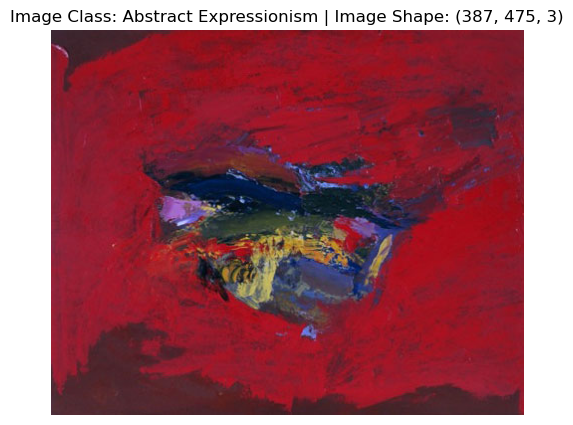

In [24]:
# Get all image path
path = Path(final_directory)
image_path_list = list(path.glob("*/*/*.jpg"))

# Random image
image_path = random.choice(image_path_list)
# Get image class
image_class = image_path.parent.stem # stem -> end of image folder 
# Open image
img = Image.open(image_path)
img_array = np.asarray(img)

plt.figure(figsize=(12,5))
plt.imshow(img_array)
plt.title(f"Image Class: {image_class} | Image Shape: {img_array.shape}")
plt.axis(False);

# Pytorch defeault color channel -> (3,H,W)

### Transforming Image Data

1. Converting image data into Tensors
2. Then converting to ```Dataset``` and ```DataLoader```

In [25]:
# Transform for images

data_transform_train = transforms.Compose([
    # Resize the images to 128x128
    transforms.Resize(size=(128,128)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
])

data_transform_val = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.ToTensor(),
])

data_transform_test = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.ToTensor(),
])




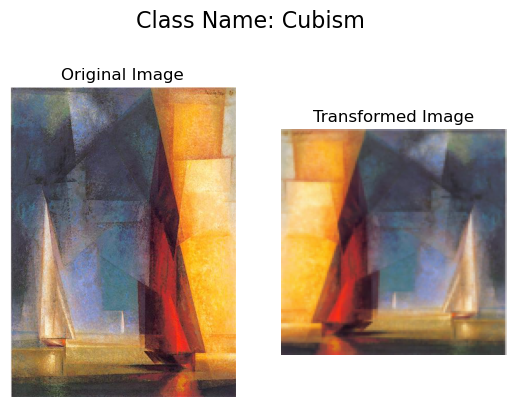

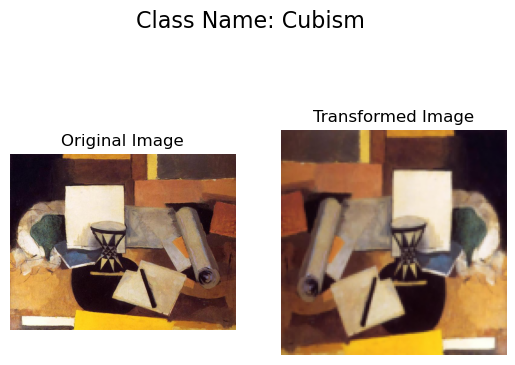

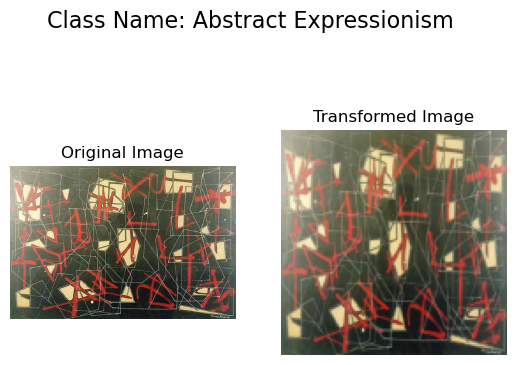

In [26]:
def plot_images(image_path: list, transform, n=3, seed=None):

    """ Select random images and transforming the images and
     plotting original vs tranformed image """
    
    if seed:
        random.seed(seed)

    image_path = random.sample(image_path_list, k=n)
    # print(image_path)
    for path in image_path:
        with Image.open(path) as p:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(p)
            ax[0].set_title("Original Image")
            ax[0].axis(False)


            transform_image = transform(p).permute(1,2,0) # changing shape (C,H,W) -> (H,W,C)
            ax[1].imshow(transform_image)
            ax[1].set_title("Transformed Image")
            ax[1].axis(False)

            fig.suptitle(f"Class Name: {path.parent.stem}", fontsize=16)

plot_images(image_path=image_path_list,
            transform=data_transform_train,
            n=3,
            seed=42)




### Loading image data using ```ImageFolder```

In [27]:
train_data = datasets.ImageFolder(root=final_train_directory,
                                  transform=data_transform_train,
                                  target_transform=None) # because it is in generic folder structure/folder_name is the class name 


val_data = datasets.ImageFolder(root=final_val_directory,
                                 transform=data_transform_val)


test_data = datasets.ImageFolder(root=final_test_directory,
                                 transform=data_transform_test)




train_data, val_data, test_data


(Dataset ImageFolder
     Number of datapoints: 17145
     Root location: /kaggle/working/Dataset/Train
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 3675
     Root location: /kaggle/working/Dataset/Val
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 3673
     Root location: /kaggle/working/Dataset/Test
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ))

In [28]:
class_names = train_data.classes
print(f"List of Class Names: {class_names}")

List of Class Names: ['Abstract Expressionism', 'Academicism', 'Cubism', 'Minimalism', 'Neoclassicism', 'Northern Renaissance', 'Pop Art', 'Rococo']


In [29]:
# check the length of our dataset
print(f"Size of Train Data {len(train_data)}")
print(f"Size of Validation Data {len(val_data)}")
print(f"Size of Train Data {len(test_data)}")

Size of Train Data 17145
Size of Validation Data 3675
Size of Train Data 3673


In [30]:
# Index on the train_data Dataset to get single image and label
img, label = train_data[0][0], train_data[0][1]

print(f"Image Tensor: {img}")
print(f"Image shape: {img.shape}")
print(f"Image type: {img.dtype}")
print(f"Image label: {label} and Image Class: {class_names[label]}")

Image Tensor: tensor([[[0.9725, 0.9569, 0.9490,  ..., 0.9255, 0.9255, 0.9373],
         [0.9412, 0.9373, 0.9373,  ..., 0.9216, 0.9137, 0.9216],
         [0.9412, 0.9373, 0.9373,  ..., 0.8118, 0.8196, 0.8314],
         ...,
         [0.9451, 0.9373, 0.9176,  ..., 0.4902, 0.4745, 0.4902],
         [0.9451, 0.9373, 0.9059,  ..., 0.8941, 0.8745, 0.8863],
         [0.9451, 0.9373, 0.9098,  ..., 0.9529, 0.9333, 0.9333]],

        [[0.9294, 0.9137, 0.9059,  ..., 0.8902, 0.8941, 0.8980],
         [0.8902, 0.8863, 0.8863,  ..., 0.8706, 0.8784, 0.8824],
         [0.8941, 0.8902, 0.8863,  ..., 0.8000, 0.8196, 0.8275],
         ...,
         [0.8706, 0.8667, 0.8157,  ..., 0.6353, 0.6275, 0.6549],
         [0.8706, 0.8667, 0.8039,  ..., 0.8667, 0.8667, 0.8863],
         [0.8784, 0.8667, 0.8078,  ..., 0.9020, 0.9059, 0.9098]],

        [[0.9098, 0.8627, 0.8431,  ..., 0.7686, 0.7882, 0.8235],
         [0.8588, 0.8392, 0.8353,  ..., 0.7765, 0.7686, 0.7922],
         [0.8549, 0.8431, 0.8392,  ..., 0.72

Original Shape: torch.Size([3, 128, 128])
Permuted Shape: torch.Size([128, 128, 3])


(-0.5, 127.5, 127.5, -0.5)

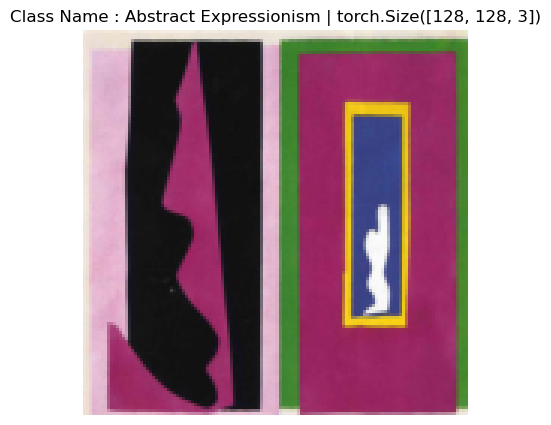

In [31]:
img_permute = img.permute(1,2,0)

print(f"Original Shape: {img.shape}")
print(f"Permuted Shape: {img_permute.shape}")

plt.figure(figsize=(12,5))
plt.imshow(img_permute)
plt.title(f"Class Name : {class_names[label]} | {img_permute.shape}")
plt.axis(False)

### Loading images in a DataLoader

DataLoaders -> ```dataloader``` helps the datasets into iterables and we can customize the images to a ```batch_size``` 

In [32]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=2,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_data,
                            batch_size=BATCH_SIZE,
                            num_workers=2,
                            shuffle=False)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=2,
                             shuffle=False)


In [33]:
train_dataloader, val_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a2ffba1f190>,
 <torch.utils.data.dataloader.DataLoader at 0x7a2ffba1f310>)

In [34]:
len(train_dataloader), len(train_data)

(536, 17145)

In [35]:
img, label = next(iter(train_dataloader))

print(f"img shape: {img.shape}")
print(f"img label: {label.shape}")

img shape: torch.Size([32, 3, 128, 128])
img label: torch.Size([32])


### Building custom model - ```Model_0```

In [36]:
from torch.nn.modules.pooling import MaxPool2d

class Model_0(nn.Module):
    """
    Custom model - Model_0
    """
    def __init__(self, input_shape:int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        
        

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=20,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(20), # helps to stabilize the training process and speed up convergence
            nn.ReLU(),
            nn.Conv2d(in_channels=20,
                      out_channels=20,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, # Reduce the dimensions of the tensor while retaining important features.
                     stride=2)

        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=20,
                      out_channels=25,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(25),
            nn.ReLU(),
            nn.Conv2d(in_channels=25,
                      out_channels=25,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(25),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                     stride=2)

        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=25,
                      out_channels=25,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(25),
            nn.ReLU(),
            nn.Conv2d(in_channels=25,
                      out_channels=30,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(30),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(in_channels=30,
                      out_channels=30,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(30),
            nn.ReLU(),
            nn.Conv2d(in_channels=30,
                      out_channels=30,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(30),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        
        self.conv_block_5 = nn.Sequential(
            nn.Conv2d(in_channels=30,
                      out_channels=30,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(30),
            nn.ReLU(),
            nn.Conv2d(in_channels=30,
                      out_channels=35,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(35),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )



        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=35*4*4,
                      out_features=output_shape)
        )

    def forward(self, x):

#         x = self.conv_block_1(x)
#         x = self.conv_block_2(x)
#         x = self.conv_block_3(x)
#         x = self.conv_block_4(x)
#         x = self.conv_block_5(x)
#         x = self.classifier(x)

#         return x
        return self.classifier(self.conv_block_5(self.conv_block_4(self.conv_block_3(self.conv_block_2(self.conv_block_1(x))))))
    

In [37]:
model_0 = Model_0(input_shape=3, # Number of color channels in our image data
                  hidden_units=None,
                  output_shape=len(class_names)).to(device)

model_0

Model_0(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(20, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0

### Try forward pass in for a single image

In [38]:
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

### Torch Summary of Model

In [39]:
summary(model_0, input_size=[32,3,128,128])

Layer (type:depth-idx)                   Output Shape              Param #
Model_0                                  [32, 8]                   --
├─Sequential: 1-1                        [32, 20, 64, 64]          --
│    └─Conv2d: 2-1                       [32, 20, 128, 128]        560
│    └─BatchNorm2d: 2-2                  [32, 20, 128, 128]        40
│    └─ReLU: 2-3                         [32, 20, 128, 128]        --
│    └─Conv2d: 2-4                       [32, 20, 128, 128]        3,620
│    └─BatchNorm2d: 2-5                  [32, 20, 128, 128]        40
│    └─ReLU: 2-6                         [32, 20, 128, 128]        --
│    └─MaxPool2d: 2-7                    [32, 20, 64, 64]          --
├─Sequential: 1-2                        [32, 25, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 25, 64, 64]          4,525
│    └─BatchNorm2d: 2-9                  [32, 25, 64, 64]          50
│    └─ReLU: 2-10                        [32, 25, 64, 64]          --
│    └─C

In [40]:
# Try forward Pass
model_0(image_batch.to(device))

tensor([[-0.3410,  0.0229, -0.5391,  0.4619, -0.2075,  0.1639,  0.0177, -0.3919],
        [ 0.2065, -0.6129, -0.5184,  0.8709,  0.5824,  0.2862,  0.2035, -0.2261],
        [-0.2140, -0.1169, -1.1806,  0.4285,  0.0831,  0.5324, -0.0583, -0.5150],
        [-0.1235,  0.3452, -0.7732,  0.7984,  0.9319, -0.3235,  0.1264, -0.3989],
        [-0.2224,  0.0356, -0.3702,  0.8421,  0.5417,  0.6208,  0.3018, -0.6462],
        [-0.1691,  0.4837, -0.0653,  0.7842,  0.6542, -0.2328,  0.7442, -0.8864],
        [ 0.0210,  0.2703, -0.9441,  0.8075,  0.6966, -0.1875, -0.0449, -0.3016],
        [-0.3586,  0.6953, -1.1567,  1.0894,  0.1174,  0.7678,  0.0609, -0.4755],
        [-0.1974,  0.1762, -0.8897,  0.2497,  0.2769,  0.0637,  0.5357, -0.3812],
        [-0.3292, -0.1683, -0.1683,  1.2465,  1.3090,  0.8695,  0.6353, -0.8970],
        [-1.3299,  1.3990,  0.0830,  0.0957,  1.9793, -0.0271,  0.3287, -1.3327],
        [-0.4309,  0.1763, -0.2633,  0.5426, -0.0358, -0.0930, -0.1771, -0.2131],
        [ 0.0746

## Training and Testing the model

#### Setup loss function and optimizer

In [41]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_0.parameters(),
                            lr=0.01)

### Training Model

In [42]:
def train_model(model: torch.nn.Module,
                dataloader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer:torch.optim.Optimizer,
                device=device):
    
    # Put the model in train mode
    model.train()

    # setup train loss and accuracy values
    train_loss, train_acc = 0, 0

    # Looping through dataloader
    for batch, (X,y) in enumerate(dataloader):

        X, y = X.to(device), y.to(device)

        # Forward Pass
        y_pred = model(X) # raw output of model -> logits

        # Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # OPtimizer Zero grad
        optimizer.zero_grad()

        # Backward Propogation
        loss.backward()

        # Optimizer Step
        optimizer.step()

        # Calcualte Acc
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred) # dividing the number of correctly classified samples by the total number of samples in the batch.
    
    train_loss = train_loss / len(dataloader) # calcuating loss by dividing overall loss by number of batches
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [43]:
def val_model(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    
  
    model.eval()

    val_loss, val_acc = 0, 0

    with torch.inference_mode(): # disable gradient tracking

        for batch, (X,y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)

            val_pred_logits = model(X)

            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += ((val_pred_labels == y).sum().item() / len(val_pred_labels))

    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)

    return val_loss, val_acc
  

In [44]:
def train_whole_model(model: torch.nn.Module,
                      train_dataloader: torch.utils.data.DataLoader,
                      val_dataloader: torch.utils.data.DataLoader,
                      optimizer: torch.optim.Optimizer,
                      loss_fn: torch.nn.Module,
                      epochs: int = 5):
    

    results = {"train_loss": [],
               "val_loss": [],
               "train_acc": [],
               "val_acc": [] }
    
    for epoch in tqdm(range(epochs)):

        train_loss, train_acc = train_model(model=model,
                                            dataloader=train_dataloader,
                                            optimizer=optimizer,
                                            loss_fn=loss_fn)
      
        val_loss, val_acc = val_model(model=model,
                                      dataloader=val_dataloader,
                                      loss_fn=loss_fn)
        
        
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.2f} | Train Acc: {train_acc:.2f} | Val Loss: {val_loss:.2f} | Val Acc: {val_acc:.2f}")


        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    return results

In [45]:
model_0.to(device)

Model_0(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(20, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0

In [46]:
start_time = timer()

model_0_results = train_whole_model(model=model_0,
                                    train_dataloader=train_dataloader,
                                    val_dataloader=val_dataloader,
                                    optimizer=optimizer,
                                    loss_fn=loss_fn,
                                    epochs=10)

end_time = timer()

final_time = end_time - start_time
print(f"Time taken to training the model : {final_time/60:.3f} minutes.")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.92 | Train Acc: 0.26 | Val Loss: 2.28 | Val Acc: 0.19
Epoch: 1 | Train Loss: 1.72 | Train Acc: 0.32 | Val Loss: 1.71 | Val Acc: 0.34
Epoch: 2 | Train Loss: 1.61 | Train Acc: 0.37 | Val Loss: 2.63 | Val Acc: 0.23
Epoch: 3 | Train Loss: 1.50 | Train Acc: 0.41 | Val Loss: 1.44 | Val Acc: 0.43
Epoch: 4 | Train Loss: 1.42 | Train Acc: 0.44 | Val Loss: 1.43 | Val Acc: 0.43
Epoch: 5 | Train Loss: 1.37 | Train Acc: 0.46 | Val Loss: 1.39 | Val Acc: 0.47
Epoch: 6 | Train Loss: 1.33 | Train Acc: 0.48 | Val Loss: 1.31 | Val Acc: 0.50
Epoch: 7 | Train Loss: 1.30 | Train Acc: 0.49 | Val Loss: 1.45 | Val Acc: 0.46
Epoch: 8 | Train Loss: 1.27 | Train Acc: 0.50 | Val Loss: 1.28 | Val Acc: 0.49
Epoch: 9 | Train Loss: 1.25 | Train Acc: 0.52 | Val Loss: 1.36 | Val Acc: 0.49
Time taken to training the model : 19.569 minutes.


#### Plot loss curves

In [48]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """ Plot loss curves of result directionary (train and validation)"""

    train_loss = results["train_loss"]
    val_loss = results["val_loss"]

    train_acc = results["train_acc"]
    val_acc = results["val_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(14,8))

    plt.subplot(1,2,1)
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.title("LOSS")
    plt.xlabel("epochs")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(epochs, train_acc, label="Train Accuracy")
    plt.plot(epochs, val_acc, label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()


    plt.savefig("updated_model_0.jpg")
    plt.show()



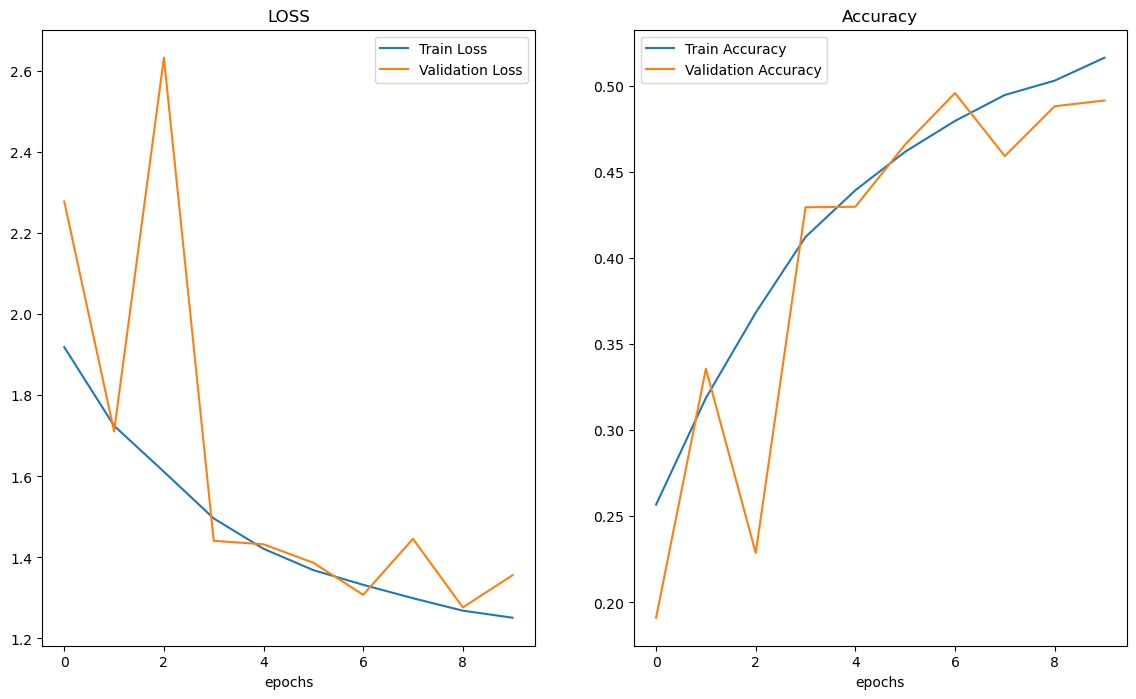

In [49]:
plot_loss_curves(model_0_results)

### <font color="Orange"> Implementation using VGG16 by freezing the parameters </font>

**Transformation for VGG**

- ```VGG-16``` takes input size of image -> ```224 x 224```

In [84]:
data_transform_vgg_train = transforms.Compose([
    transforms.Resize(size=(224,224)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

data_transform_vgg_val = transforms.Compose([
    transforms.Resize(size=(224,224)),
    # transforms.CenterCrop(224),
    transforms.ToTensor()
])

data_transform_vgg_test = transforms.Compose([
    transforms.Resize(size=(224,224)),
    # transforms.CenterCrop(224),
    transforms.ToTensor()
])

In [85]:
train_data_vgg = datasets.ImageFolder(root=final_train_directory,
                                      transform=data_transform_vgg_train)

val_data_vgg = datasets.ImageFolder(root=final_val_directory,
                                      transform=data_transform_vgg_val)

test_data_vgg = datasets.ImageFolder(root=final_test_directory,
                                     transform=data_transform_vgg_test)

In [86]:
len(train_data_vgg.classes)

8

In [87]:
BATCH_SIZE_VGG = 32 

train_dataloader_vgg = DataLoader(dataset=train_data_vgg,
                                  batch_size=BATCH_SIZE_VGG,
                                  shuffle=True,
                                  num_workers=2)

val_dataloader_vgg = DataLoader(dataset=val_data_vgg,
                                  batch_size=BATCH_SIZE_VGG,
                                  shuffle=True,
                                  num_workers=2)

test_dataloader_vgg = DataLoader(dataset=test_data_vgg,
                                  batch_size=BATCH_SIZE_VGG,
                                  shuffle=False,
                                  num_workers=2)

In [88]:
vgg_image_batch, vgg_label_batch = next(iter(train_dataloader_vgg))
vgg_image_batch.shape, vgg_label_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [89]:
vgg_model = models.vgg16(pretrained=True)
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [90]:
for params in vgg_model.parameters():
  params.requires_grad = False

n_inputs = vgg_model.classifier[6].in_features
print(n_inputs)

4096


In [91]:
 vgg_model.classifier[6] = nn.Sequential(
     nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
     nn.Linear(256, len(train_data_vgg.classes), nn.LogSoftmax(dim=1)))

In [92]:
total_params = sum(p.numel() for p in vgg_model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in vgg_model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,311,432 total parameters.
1,050,888 training parameters.


In [93]:
vgg_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [69]:
summary(vgg_model.to(device), input_size=[32, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [32, 8]                   --
├─Sequential: 1-1                        [32, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [32, 64, 224, 224]        (1,792)
│    └─ReLU: 2-2                         [32, 64, 224, 224]        --
│    └─Conv2d: 2-3                       [32, 64, 224, 224]        (36,928)
│    └─ReLU: 2-4                         [32, 64, 224, 224]        --
│    └─MaxPool2d: 2-5                    [32, 64, 112, 112]        --
│    └─Conv2d: 2-6                       [32, 128, 112, 112]       (73,856)
│    └─ReLU: 2-7                         [32, 128, 112, 112]       --
│    └─Conv2d: 2-8                       [32, 128, 112, 112]       (147,584)
│    └─ReLU: 2-9                         [32, 128, 112, 112]       --
│    └─MaxPool2d: 2-10                   [32, 128, 56, 56]         --
│    └─Conv2d: 2-11                      [32, 256, 56, 56]   

In [94]:
vgg_loss_fn = nn.CrossEntropyLoss()
vgg_optimizer = torch.optim.SGD(params=vgg_model.classifier.parameters(),
                                lr=0.01)

In [95]:
start_time = timer()

model_vgg_results = train_whole_model(model=vgg_model,
                              train_dataloader=train_dataloader_vgg,
                              val_dataloader=val_dataloader_vgg,
                              optimizer=vgg_optimizer,
                              loss_fn=vgg_loss_fn,
                              epochs=5)

end_time = timer()

final_time = end_time - start_time
print(f"Train Time : {final_time/60:.3f} minutes.")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.38 | Train Acc: 0.47 | Val Loss: 1.15 | Val Acc: 0.56
Epoch: 1 | Train Loss: 1.15 | Train Acc: 0.55 | Val Loss: 1.10 | Val Acc: 0.58
Epoch: 2 | Train Loss: 1.10 | Train Acc: 0.57 | Val Loss: 1.05 | Val Acc: 0.60
Epoch: 3 | Train Loss: 1.06 | Train Acc: 0.59 | Val Loss: 1.02 | Val Acc: 0.61
Epoch: 4 | Train Loss: 1.04 | Train Acc: 0.60 | Val Loss: 1.01 | Val Acc: 0.61
Train Time : 13.162 minutes.


In [96]:
model_vgg_results

{'train_loss': [1.3788491386048338,
  1.1539428947453803,
  1.0951244989608198,
  1.0627341735447553,
  1.0387555658817291],
 'val_loss': [1.1507475991559222,
  1.098047453698104,
  1.0467008051833486,
  1.0239844436083383,
  1.009870063967821],
 'train_acc': [0.4744332573454914,
  0.5521229103343466,
  0.5719905648429584,
  0.5875443262411347,
  0.6014358535967579],
 'val_acc': [0.5620644599303136,
  0.5831518583042973,
  0.5952380952380952,
  0.6079776422764228,
  0.6121152729384437]}

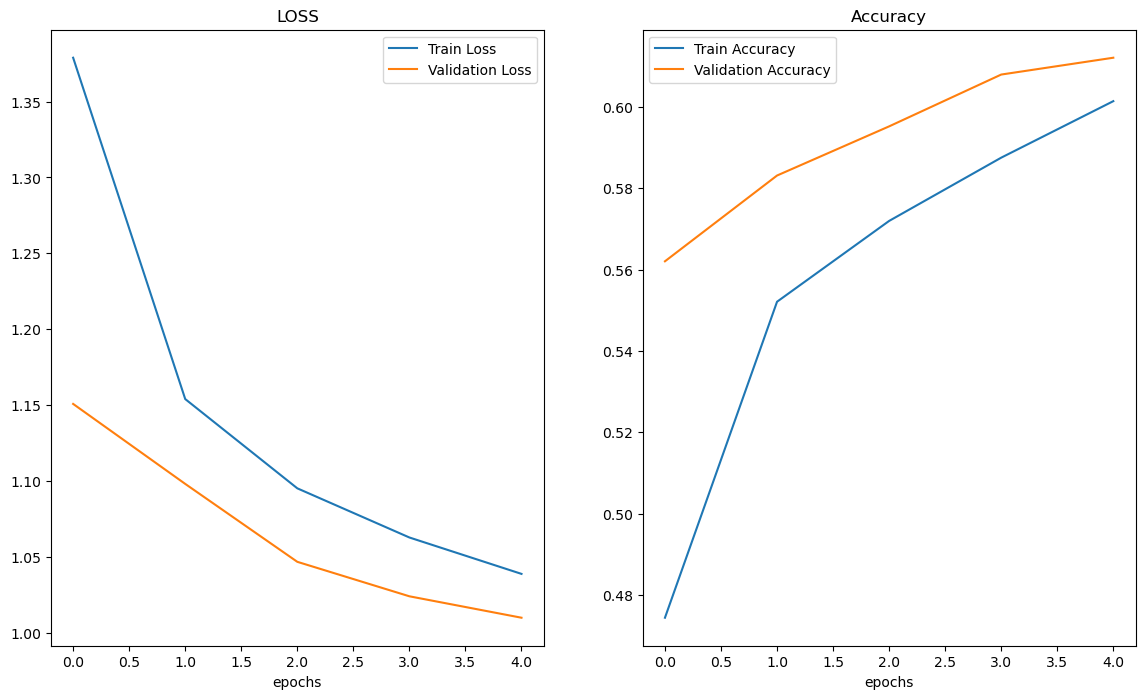

In [98]:
plot_loss_curves(model_vgg_results)

### Training using Vgg16 by unfreezing the parameters

In [100]:
for params in vgg_model.parameters():
  params.requires_grad = True

In [101]:
total_params = sum(p.numel() for p in vgg_model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in vgg_model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,311,432 total parameters.
135,311,432 training parameters.


In [102]:
vgg_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [104]:
start_time = timer()

model_vgg_results_unfreeze = train_whole_model(model=vgg_model,
                              train_dataloader=train_dataloader_vgg,
                              val_dataloader=val_dataloader_vgg,
                              optimizer=vgg_optimizer,
                              loss_fn=vgg_loss_fn,
                              epochs=5)

end_time = timer()

final_time = end_time - start_time
print(f"Train Time : {final_time/60:.3f} minutes.")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 0.96 | Train Acc: 0.63 | Val Loss: 0.92 | Val Acc: 0.63
Epoch: 1 | Train Loss: 0.83 | Train Acc: 0.68 | Val Loss: 0.87 | Val Acc: 0.66
Epoch: 2 | Train Loss: 0.74 | Train Acc: 0.71 | Val Loss: 0.85 | Val Acc: 0.68
Epoch: 3 | Train Loss: 0.66 | Train Acc: 0.74 | Val Loss: 0.84 | Val Acc: 0.68
Epoch: 4 | Train Loss: 0.58 | Train Acc: 0.77 | Val Loss: 0.83 | Val Acc: 0.69
Train Time : 15.443 minutes.


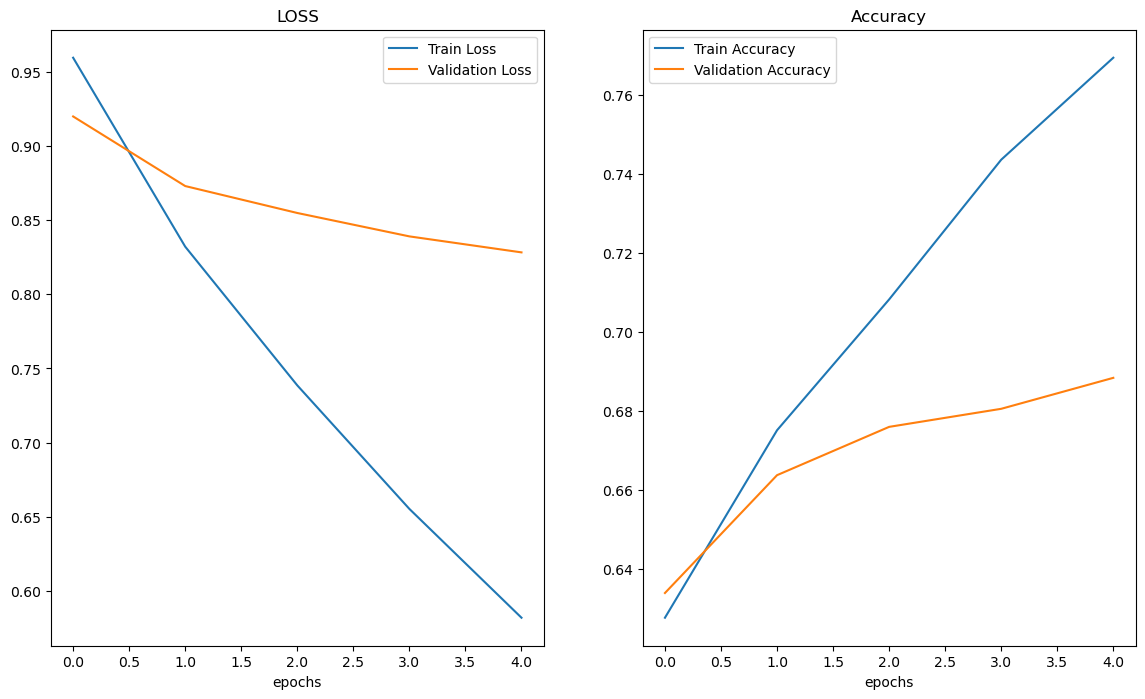

In [106]:
plot_loss_curves(model_vgg_results_unfreeze)

## Training using ResNet50

In [71]:
resnet_model = models.resnet50(pretrained=True)
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [72]:
for params in resnet_model.parameters():
    params.requires_grad = False

n_inputs_resnet = resnet_model.fc.in_features
print(n_inputs_resnet)

resnet_model.fc = nn.Linear(n_inputs_resnet, len(train_data_vgg.classes))
resnet_model.to(device)


2048


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [73]:
total_params = sum(p.numel() for p in resnet_model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in resnet_model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

23,524,424 total parameters.
16,392 training parameters.


In [74]:
resnet_loss_fn = nn.CrossEntropyLoss()
resnet_optimizer = torch.optim.SGD(params=resnet_model.parameters(),
                                lr=0.01)

In [75]:
start_time = timer()

model_resnet_results = train_whole_model(model=resnet_model,
                              train_dataloader=train_dataloader,
                              val_dataloader=val_dataloader,
                              optimizer=resnet_optimizer,
                              loss_fn=resnet_loss_fn,
                              epochs=10)

end_time = timer()

final_time = end_time - start_time
print(f"Training Time : {final_time/60:.3f} minutes.")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.33 | Train Acc: 0.50 | Val Loss: 1.17 | Val Acc: 0.56
Epoch: 1 | Train Loss: 1.13 | Train Acc: 0.58 | Val Loss: 1.12 | Val Acc: 0.56
Epoch: 2 | Train Loss: 1.08 | Train Acc: 0.59 | Val Loss: 1.07 | Val Acc: 0.59
Epoch: 3 | Train Loss: 1.05 | Train Acc: 0.60 | Val Loss: 1.07 | Val Acc: 0.58
Epoch: 4 | Train Loss: 1.03 | Train Acc: 0.61 | Val Loss: 1.06 | Val Acc: 0.59
Epoch: 5 | Train Loss: 1.02 | Train Acc: 0.61 | Val Loss: 1.05 | Val Acc: 0.59
Epoch: 6 | Train Loss: 1.01 | Train Acc: 0.62 | Val Loss: 1.06 | Val Acc: 0.60
Epoch: 7 | Train Loss: 0.99 | Train Acc: 0.62 | Val Loss: 1.07 | Val Acc: 0.59
Epoch: 8 | Train Loss: 0.99 | Train Acc: 0.63 | Val Loss: 1.06 | Val Acc: 0.57
Epoch: 9 | Train Loss: 0.98 | Train Acc: 0.63 | Val Loss: 1.02 | Val Acc: 0.61
Training Time : 21.384 minutes.


In [76]:
model_resnet_results

{'train_loss': [1.3288148246335645,
  1.1255309747677322,
  1.084393543448854,
  1.0536829107407983,
  1.0307561256361346,
  1.0207593792930563,
  1.0057722795622568,
  0.9946301901805485,
  0.9872289792442999,
  0.9822623526796381],
 'val_loss': [1.1677935717067098,
  1.1181897467714015,
  1.0718330282990525,
  1.0703889204234611,
  1.0563328161956818,
  1.05282564885248,
  1.0550056514216632,
  1.0748843116973474,
  1.0561703951135883,
  1.0217951979578994],
 'train_acc': [0.5041160081053698,
  0.576114488348531,
  0.5872514564336373,
  0.6048473910840931,
  0.6101427938196555,
  0.6091533687943262,
  0.6162455673758865,
  0.6220554711246201,
  0.6263139564336373,
  0.6281107522796352],
 'val_acc': [0.5579631242740999,
  0.560140824622532,
  0.5924070847851336,
  0.5780342624854821,
  0.5893583042973287,
  0.5918989547038328,
  0.5958188153310106,
  0.5854021486643438,
  0.5711745063879211,
  0.6090301974448317]}

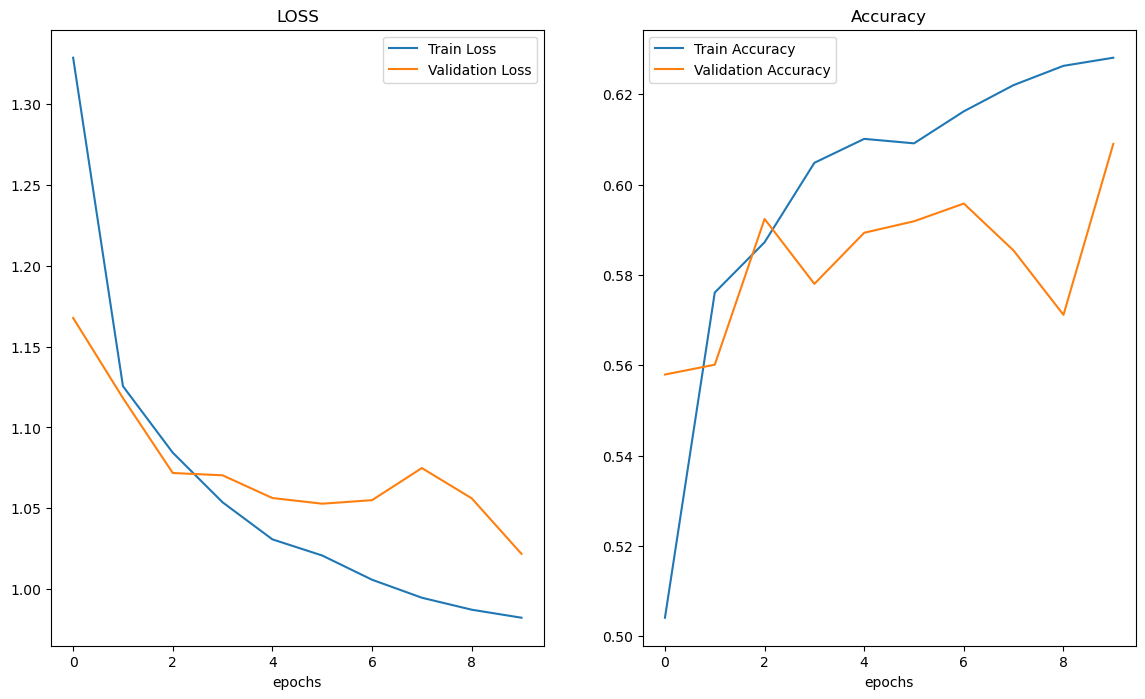

In [78]:
plot_loss_curves(model_resnet_results)

### Training on ResNet-50 by unfreezing the parameters

In [79]:
for params in resnet_model.parameters():
    params.requires_grad = True

n_inputs_resnet = resnet_model.fc.in_features
print(n_inputs_resnet)

resnet_model.fc = nn.Linear(n_inputs_resnet, len(train_data_vgg.classes))
resnet_model.to(device)

2048


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [80]:
total_params = sum(p.numel() for p in resnet_model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in resnet_model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

23,524,424 total parameters.
23,524,424 training parameters.


In [81]:
start_time = timer()

model_resnet_results_unfreeze = train_whole_model(model=resnet_model,
                              train_dataloader=train_dataloader,
                              val_dataloader=val_dataloader,
                              optimizer=resnet_optimizer,
                              loss_fn=resnet_loss_fn,
                              epochs=5)

end_time = timer()

final_time = end_time - start_time
print(f"Training Time : {final_time/60:.3f} minutes.")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.15 | Train Acc: 0.58 | Val Loss: 0.86 | Val Acc: 0.67
Epoch: 1 | Train Loss: 0.76 | Train Acc: 0.71 | Val Loss: 0.78 | Val Acc: 0.70
Epoch: 2 | Train Loss: 0.61 | Train Acc: 0.77 | Val Loss: 0.78 | Val Acc: 0.70
Epoch: 3 | Train Loss: 0.49 | Train Acc: 0.81 | Val Loss: 0.78 | Val Acc: 0.71
Epoch: 4 | Train Loss: 0.41 | Train Acc: 0.85 | Val Loss: 0.73 | Val Acc: 0.73
Training Time : 11.593 minutes.


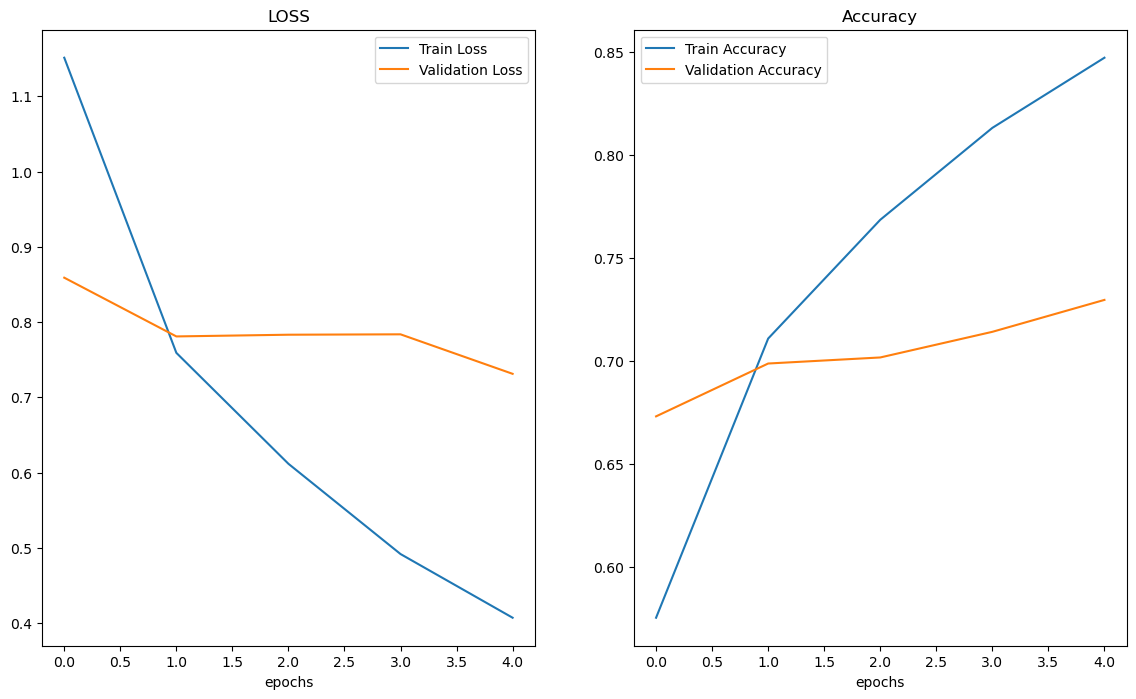

In [83]:
plot_loss_curves(model_resnet_results_unfreeze)

## Testing the custom model -> Model_0

In [50]:
def test_prediction(model:torch.nn.Module,
                   test_data: List,
                   device=device):
    
    prediction_probabilities = []
    
    model.eval()
    with torch.inference_mode():
        for data in test_data:
            # Adding an extra dimension 
            data = torch.unsqueeze(data, dim=0).to(device)
            # Foward Pass raw output (logits)
            logits = model(data)
            # get prediction probability
            pred_prob = torch.softmax(logits.squeeze(), dim=0)
            prediction_probabilities.append(pred_prob.cpu())
            
    return torch.stack(prediction_probabilities) # converting list into tensor
            
            

In [51]:
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=10):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([3, 128, 128])
Test sample label: 6 (Pop Art)


In [52]:
prediction = test_prediction(model=model_0,
                            test_data=test_samples)
pred_classes = prediction.argmax(dim=1)
print(f"Prediction Classes: {pred_classes}")

print(f"Test Label Classes: {test_labels}")

Prediction Classes: tensor([6, 2, 2, 1, 0, 2, 4, 2, 6, 3])
Test Label Classes: [6, 2, 2, 1, 0, 6, 0, 6, 6, 7]


### Visualizing the output

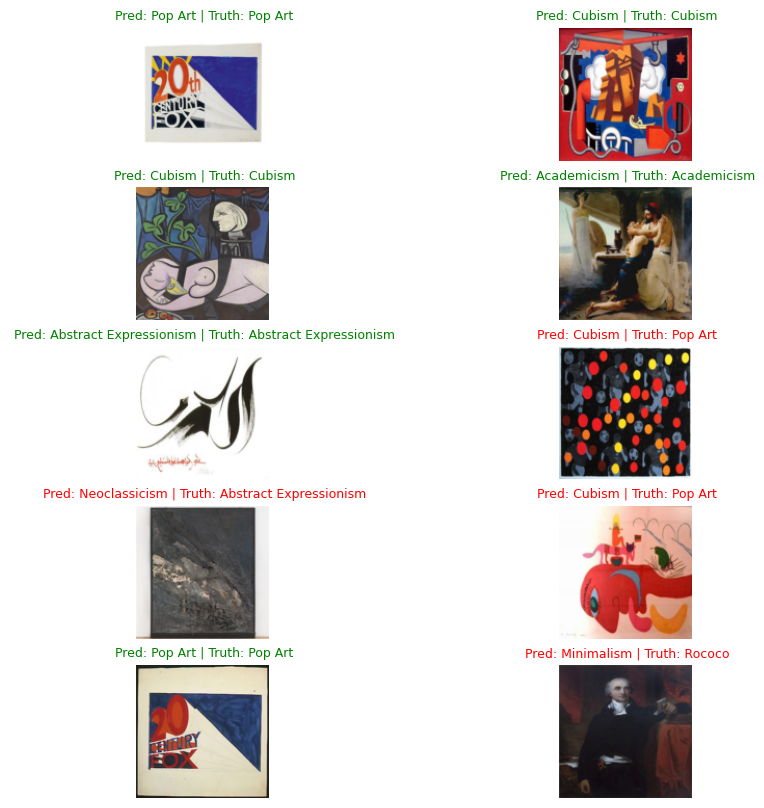

In [53]:
# Plot predictions
plt.figure(figsize=(10, 10))
nrows = 5
ncols = 2
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)
  # Plot the target image
  plt.imshow(sample.squeeze().permute(1,2,0))
  # predicted labels
  pred_label = class_names[pred_classes[i]]
  # truth labels
  truth_label = class_names[test_labels[i]] 
  # title 
  title_text = f" Pred: {pred_label} | Truth: {truth_label}"
    
  # Check if predicted label are same as truth labels
  if pred_label == truth_label:
      plt.title(title_text, fontsize=9, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=9, c="r") # red text if wrong
  plt.axis(False);
plt.savefig("Test_result.jpg")


### Confusion Matrix

In [54]:
y_preds = []
model_0.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    # forward pass
    y_logit = model_0(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

  0%|          | 0/115 [00:00<?, ?it/s]

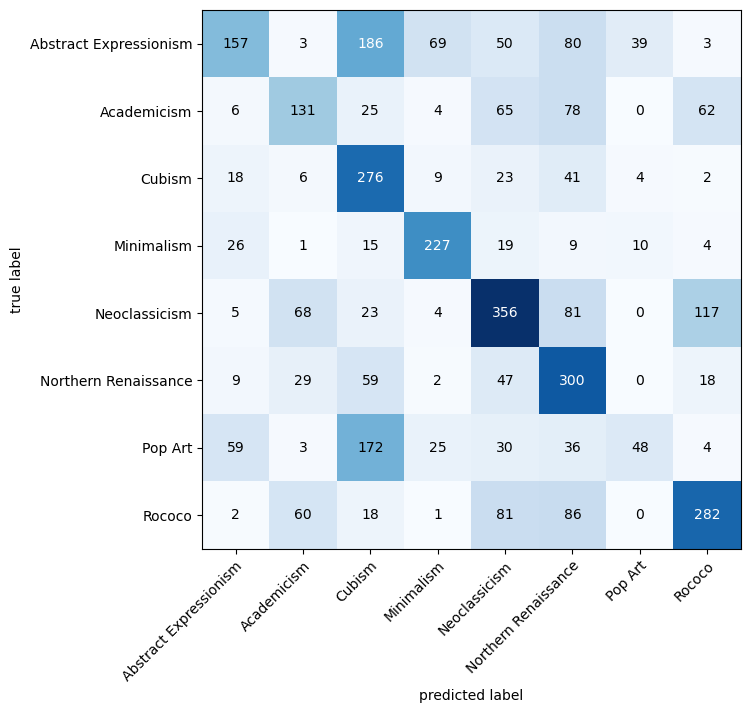

In [55]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=torch.tensor(test_data.targets))


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
);

plt.savefig("Confusion_Matrix_model_0.jpg")


### Classification Report of Model_0

In [58]:
print(classification_report(y_pred_tensor, torch.tensor(test_data.targets), target_names=class_names))

                        precision    recall  f1-score   support

Abstract Expressionism       0.27      0.56      0.36       282
           Academicism       0.35      0.44      0.39       301
                Cubism       0.73      0.36      0.48       774
            Minimalism       0.73      0.67      0.70       341
         Neoclassicism       0.54      0.53      0.54       671
  Northern Renaissance       0.65      0.42      0.51       711
               Pop Art       0.13      0.48      0.20       101
                Rococo       0.53      0.57      0.55       492

              accuracy                           0.48      3673
             macro avg       0.49      0.50      0.47      3673
          weighted avg       0.57      0.48      0.50      3673

